In [2]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
data_path ='KaggleDataset'
train_dataset = os.path.join(data_path, 'train')
test_dataset = os.path.join(data_path, 'test')
val_dataset = os.path.join(data_path,'val')

In [4]:
print('train exists:', os.path.exists(train_dataset))
print('test exists:', os.path.exists(test_dataset))
print('val exists:', os.path.exists(val_dataset))
print('\nfolders int train:', os.listdir(train_dataset) if os.path.exists(train_dataset) else 'no train folder')
print('\nfolders int test:', os.listdir(test_dataset) if os.path.exists(test_dataset) else 'no test folder')
print('\nfolders int val:', os.listdir(val_dataset) if os.path.exists(val_dataset) else 'no validation folder')

train exists: True
test exists: True
val exists: True

folders int train: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

folders int test: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

folders int val: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [5]:
# data generation to reduce overfitting
train_revise = ImageDataGenerator(
    rescale = 1./255, #normalize all the images
    width_shift_range = 0.1, #shift the image on the x-axis
    height_shift_range = 0.1, #shift the image on the y-axis
    shear_range=0.1,#tilting the image along one axis
    zoom_range=0.1,#zoom in by 10%
    horizontal_flip=True,#flips the image left-right
    fill_mode='nearest'#if there is an empty value, fill it with the nearest pixel. 
)

In [6]:
IMAGE_SIZE = (224,224)

In [7]:
val_test_revise = ImageDataGenerator(
    rescale=1./255
)

# import the dataset
train_imported = train_revise.flow_from_directory(
    train_dataset,
    target_size = IMAGE_SIZE,
    batch_size = 20
)
val_imported = val_test_revise.flow_from_directory(
    val_dataset,
    target_size = IMAGE_SIZE,
    batch_size = 20,
    shuffle = False
)
test_imported = val_test_revise.flow_from_directory(
    test_dataset,
    target_size = IMAGE_SIZE,
    batch_size = 20,
    shuffle = False
)

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 772 images belonging to 4 classes.


In [8]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding ='same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=4, activation='softmax')
])

C:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │         401,412 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,660 (1.89 MB)

 Trainable params: 494,660 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [20]:
checkpoint_path ='model_1.h5'
callbacks =[ 
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, verbose=1)]

In [21]:
model.fit(x=train_imported,
          steps_per_epoch=len(train_imported),
          validation_data=val_imported,
          validation_steps=len(val_imported),
          callbacks=callbacks,
          epochs=20,
          verbose=2,
         )

Epoch 1/20

Epoch 1: val_accuracy improved from None to 0.76316, saving model to model_1.h5


317/317 - 245s - 774ms/step - accuracy: 0.9246 - loss: 0.2145 - val_accuracy: 0.7632 - val_loss: 0.4408 - learning_rate: 1.0000e-04
Epoch 2/20

Epoch 2: val_accuracy improved from 0.76316 to 0.86842, saving model to model_1.h5


317/317 - 234s - 738ms/step - accuracy: 0.9282 - loss: 0.2093 - val_accuracy: 0.8684 - val_loss: 0.3056 - learning_rate: 1.0000e-04
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.86842
317/317 - 261s - 822ms/step - accuracy: 0.9300 - loss: 0.2038 - val_accuracy: 0.7632 - val_loss: 0.4633 - learning_rate: 1.0000e-04
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.86842
317/317 - 238s - 750ms/step - accuracy: 0.9317 - loss: 0.1954 - val_accuracy: 0.8421 - val_loss: 0.4237 - learning_rate: 1.0000e-04
Epoch 5/20

Epoch 5: val_accuracy improved from 0.86842 to 0.89474, saving model to model_1.h5


317/317 - 234s - 739ms/step - accuracy: 0.9314 - loss: 0.1949 - val_accuracy: 0.8947 - val_loss: 0.2345 - learning_rate: 1.0000e-04
Epoch 6/20

Epoch 6: val_accuracy did not improve from 0.89474
317/317 - 234s - 737ms/step - accuracy: 0.9331 - loss: 0.1923 - val_accuracy: 0.8421 - val_loss: 0.2433 - learning_rate: 1.0000e-04
Epoch 7/20

Epoch 7: val_accuracy did not improve from 0.89474
317/317 - 234s - 738ms/step - accuracy: 0.9360 - loss: 0.1855 - val_accuracy: 0.8158 - val_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 8/20

Epoch 8: val_accuracy did not improve from 0.89474

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
317/317 - 229s - 721ms/step - accuracy: 0.9369 - loss: 0.1786 - val_accuracy: 0.7895 - val_loss: 0.3505 - learning_rate: 1.0000e-04
Epoch 9/20

Epoch 9: val_accuracy did not improve from 0.89474
317/317 - 210s - 663ms/step - accuracy: 0.9491 - loss: 0.1546 - val_accuracy: 0.8421 - val_loss: 0.3343 - learning_rate: 5.0000e-05
Epoch 10/20

In [22]:
imgs, labels = next(train_imported)

In [23]:
#visualize the data
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

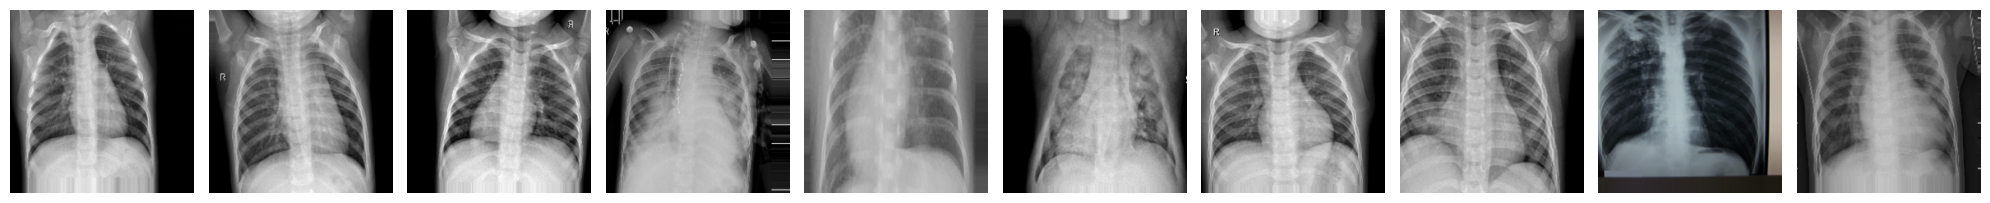

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [24]:
plotImages(imgs)
print(labels)

In [25]:
import numpy as np
import itertools

In [26]:
predictions = model.predict(x=test_imported, steps=len(test_imported),verbose=0)

In [39]:
np.round(predictions)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(772, 4), dtype=float32)

In [40]:
cm = confusion_matrix(y_true=test_imported.classes, y_pred=np.argmax(predictions, axis=-1))

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
test_imported.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}

Confusion matrix, without normalization
[[ 92   6   5   4]
 [  3 185  46   0]
 [  0  24 366   0]
 [  2   0   0  39]]


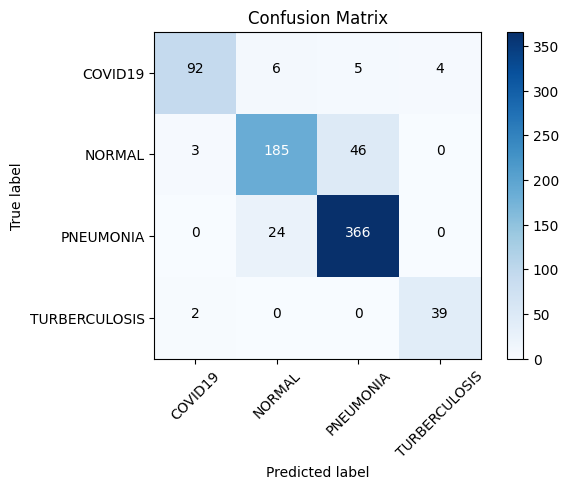

In [43]:
cm_plot_labels =['COVID19','NORMAL','PNEUMONIA','TURBERCULOSIS']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [45]:
print(os.path.exists('model_1.h5'))

True


In [86]:
last_conv_layer_name = "block14_sepconv2"

In [78]:
import keras
#Display
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
import matplotlib as mpl
import tensorflow as tf


model_builder = keras. applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

In [79]:
#image path
img_path = "KaggleDataset/test/COVID19/COVID19(460).jpg"
size = (299,299)
#load the image
img = image.load_img(img_path, target_size=(299,299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
ime_array = img_array / 255.0

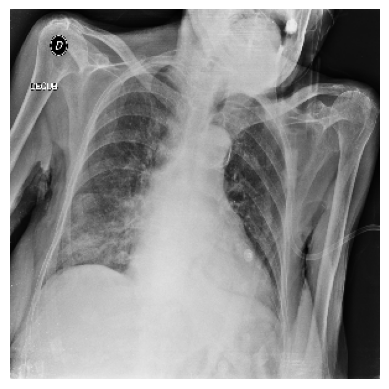

In [80]:
#visualize
plt.imshow(img)
plt.axis("off")
plt.show()

In [81]:
#Grad-CAM Algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: [('n03388043', 'fountain', np.float32(7.804894))]


C:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_706']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


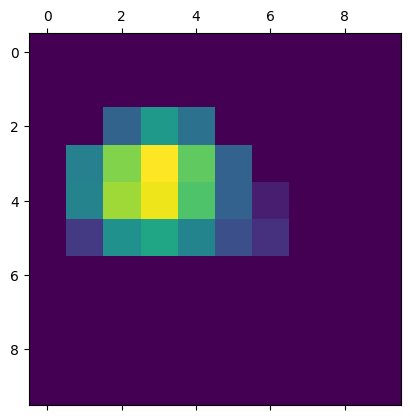

In [87]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [85]:
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 149, 149, 32)      │             864 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 149, 149, 32)      │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 149, 149, 32)      │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 147, 147, 64)      │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 147, 147, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 147, 147, 64)      │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 147, 147, 128)     │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 147, 147, 128)     │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 147, 147, 128)     │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 147, 147, 128)     │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 147, 147, 128)     │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_22 (Conv2D)            │ (None, 74, 74, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 74, 74, 128)       │               

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

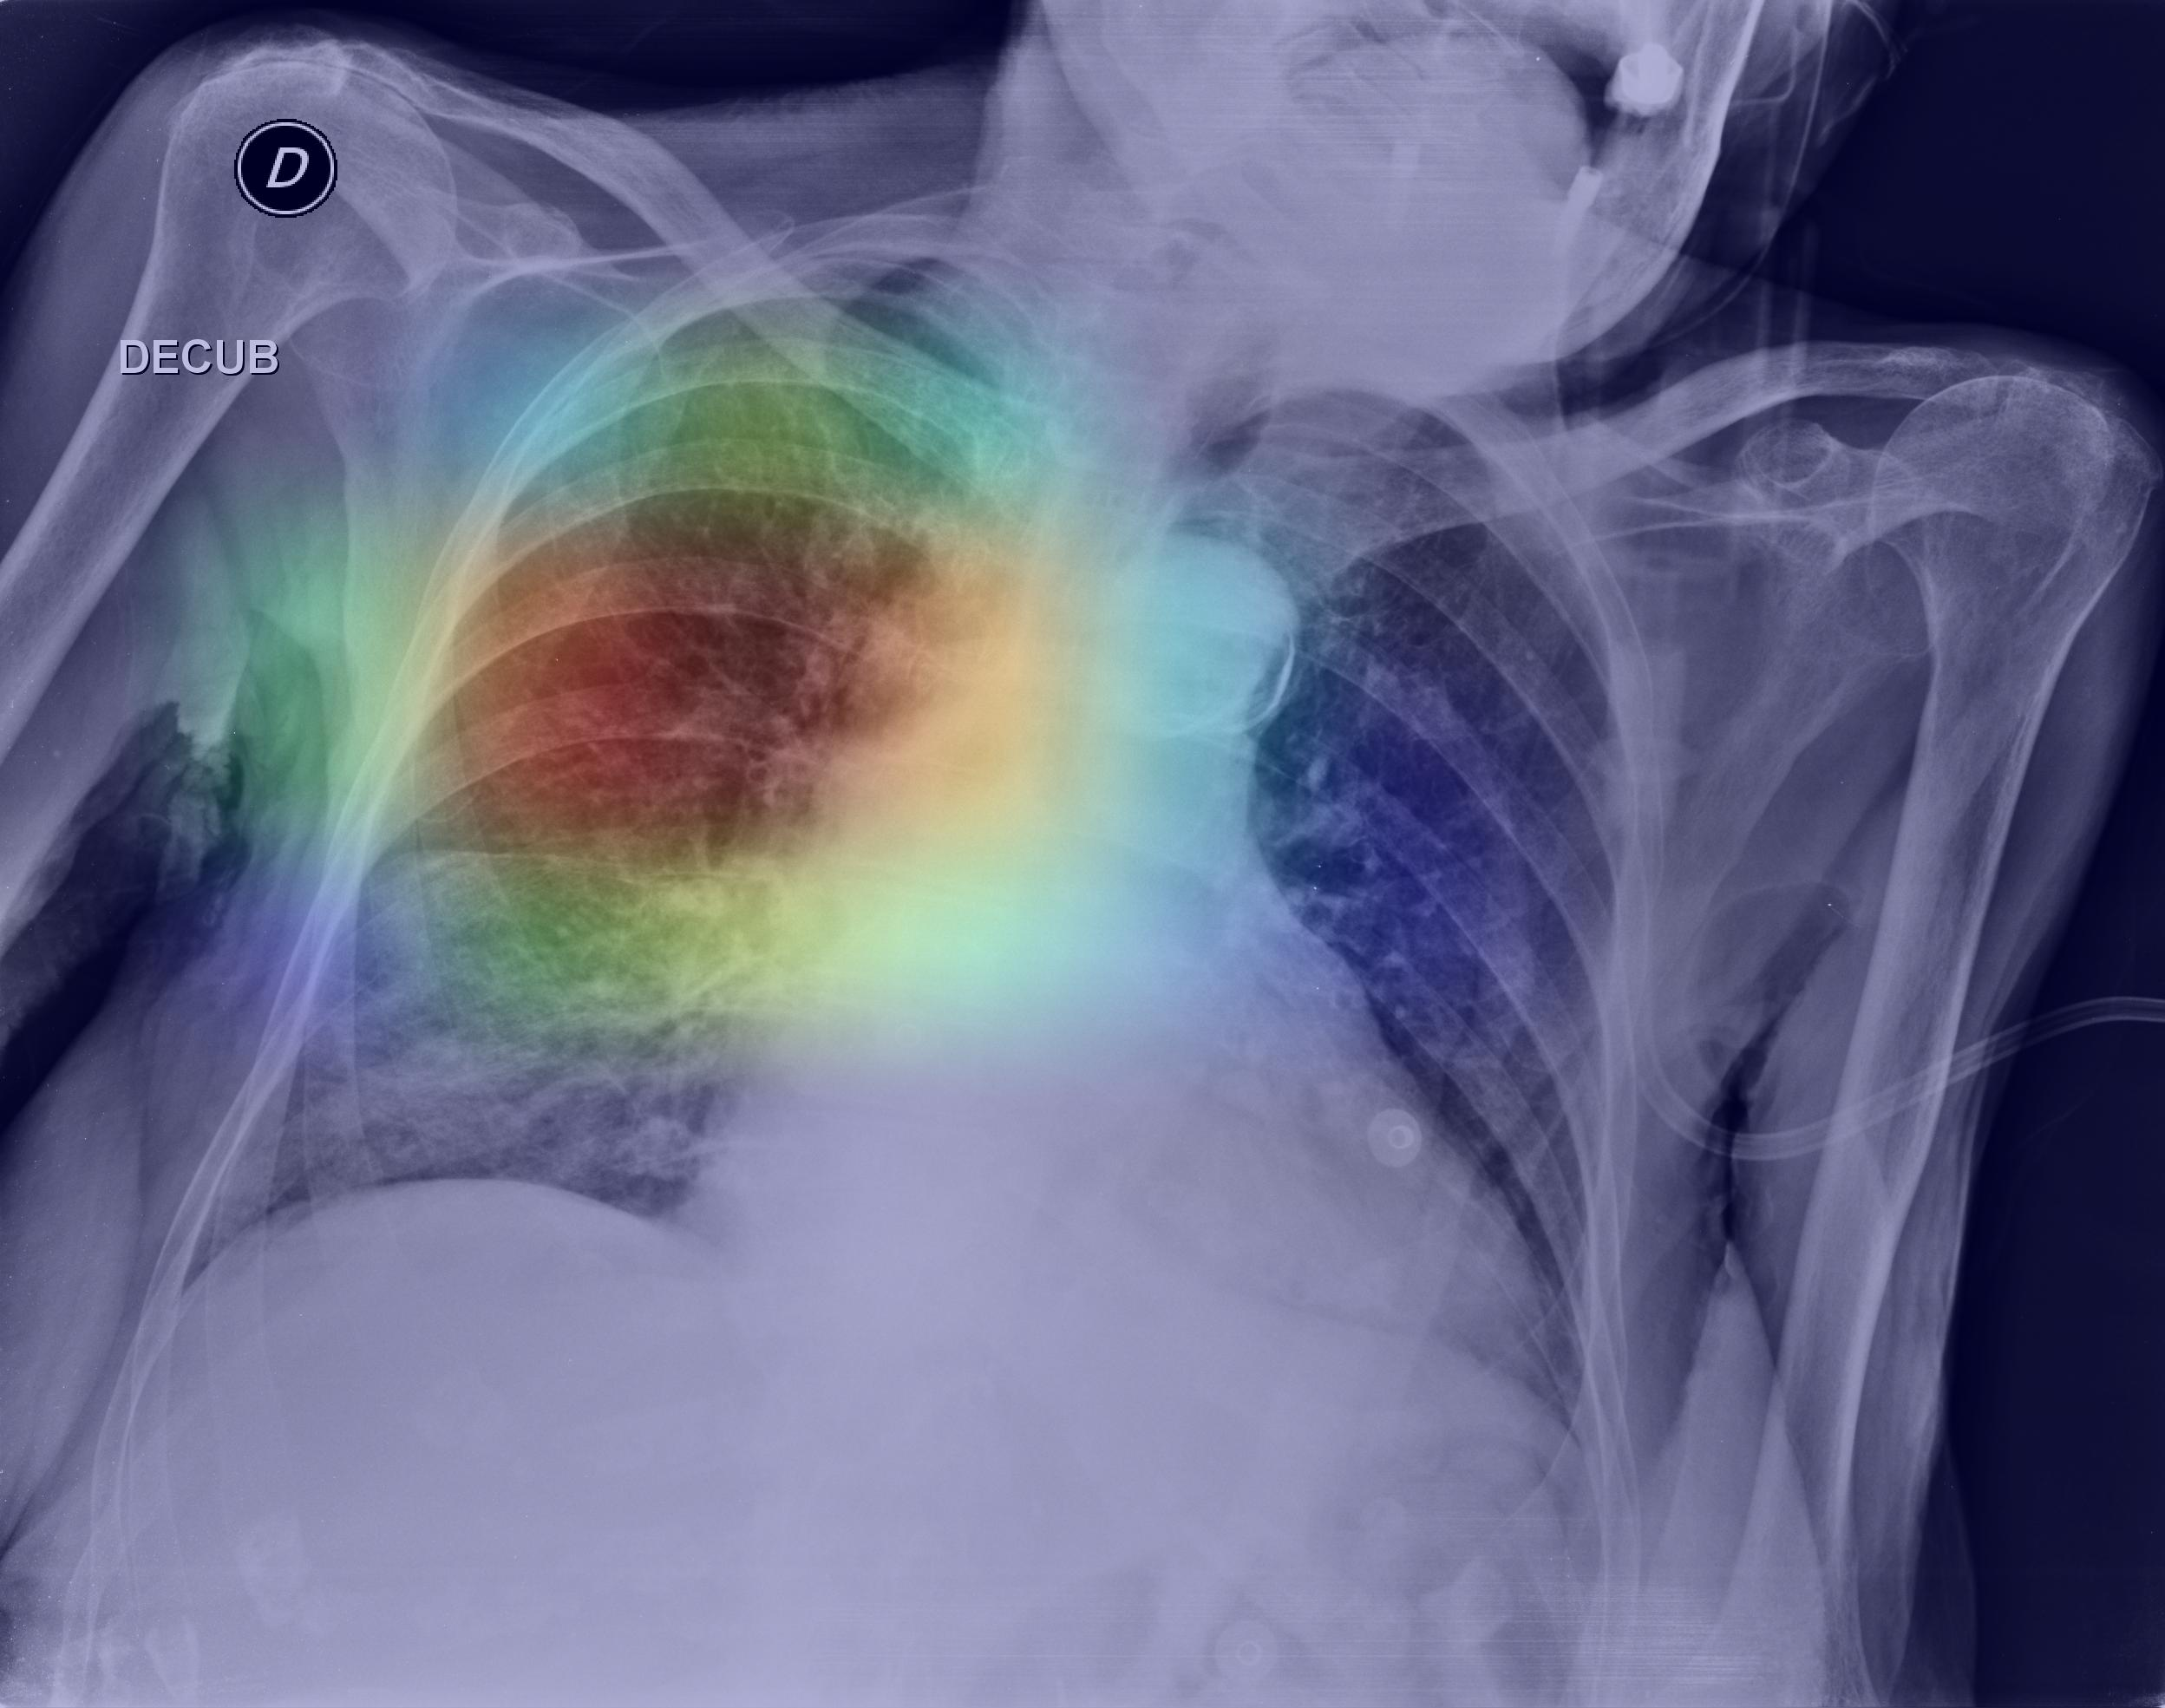

In [88]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)


In [16]:
model.save("model_2.keras")